In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential 
from keras.layers import Dense,Activation,Dropout 
from keras.layers.normalization import BatchNormalization 
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [2]:
def loadData(csv_file='ncsr_clean.csv', balance=True, random_seed=0):
    # Read csv
    df=pd.read_csv(csv_file).drop(['Unnamed: 0'], axis=1)
    df=df.loc[:293]
    
    
    np.random.seed(1)

    if balance:
        index0 = [index for index,value in enumerate(df['Y']) if value == 0]
        while 2*(df['Y']==0).sum() < len(df)-1:
            df=df.append(df.loc[index0[int(np.random.uniform()*len(index0))]])


    np.random.seed(random_seed)
    # Get x and y values
    shuffled_idx=shuffle(range(len(df)))
    shuffled_df=df.iloc[shuffled_idx]
    y=shuffled_df['Y'].values
    X=shuffled_df.drop(['Y'], axis=1)
    X=(X-X.mean())/X.std()
#     X=X/X.abs().max()
    X=X.values
    
    return X,y
    
    
    

In [43]:
def split_70_30(X, y):
    # Split
    test_size=int(np.round(0.6*len(y)))
    X_train=X[test_size:]
    X_test=X[:test_size]
    y_train=y[test_size:]
    y_test=y[:test_size]

    y_train=to_categorical(y_train, num_classes=2)
    y_test=to_categorical(y_test, num_classes=2)
    
    return X_train, X_test, y_train, y_test

In [44]:
def splitTest(X,y, test_size=0.1):
    # Split
    test_size=int(np.round(test_size*len(y)))
    X_test=X[:test_size]
    X=X[test_size:]
    y_test=y[:test_size]
    y=y[test_size:]    
    return X, X_test, y, y_test

In [45]:
def createModel():
    # Make model
    model=Sequential()
    model.add(Dense(1000,input_dim=X.shape[1],activation='relu'))
    model.add(Dense(500,activation='relu'))
    model.add(Dense(200,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation='softmax'))
    optimizer=Adam(lr=1e-5)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['binary_accuracy'])
    
    return model

In [66]:
def trainModel(model, X_train, y_train, X_test, y_test):
    # Train
    history=model.fit(X_train,y_train,validation_data=(X_test,y_test),\
              batch_size=50,\
              epochs=600,\
              verbose=0)
    return history

In [67]:
X, y=loadData(balance=True)
X, X_test, y, y_test=splitTest(X,y)
n_folds=5
skf=StratifiedKFold(n_splits=n_folds, shuffle=True)
history_list=[]
y_pred_list=[]
label_list=[]
i=0
T = []
V = []
testPredY = [[],[],[],[],[]]

for train, valid in skf.split(X, y):
    print("Fold", i+1, 'of', n_folds)
    model=None
    model=createModel()
    y_train=to_categorical(y[train], num_classes=2)
    y_valid=to_categorical(y[valid], num_classes=2)
    history=trainModel(model, X[train], y_train, X[valid], y_valid)
    history_list.append(history)
    
    y_pred=np.argmax(model.predict(X[valid]), axis=1)
    y_pred_list.append(y_pred)
    label_list.append(y_valid[:,1])
    
    T.append(history.history['binary_accuracy'][-1])
    V.append(history.history['val_binary_accuracy'][-1])
    print('Final training accuracy:', history.history['binary_accuracy'][-1])
    print('Final validation accuracy:', history.history['val_binary_accuracy'][-1])
    testPredY[i] = model.predict(X_test)
    i+=1

Fold 1 of 5
Final training accuracy: 1.0
Final validation accuracy: 0.8684210542
Fold 2 of 5
Final training accuracy: 1.0
Final validation accuracy: 0.789473696759
Fold 3 of 5
Final training accuracy: 1.0
Final validation accuracy: 0.736842105263
Fold 4 of 5
Final training accuracy: 1.0
Final validation accuracy: 0.84000001351
Fold 5 of 5
Final training accuracy: 1.0
Final validation accuracy: 0.866666654746


In [75]:
print('T acc=', np.array(T).mean())
print('V acc=', np.array(V).mean())

T acc= 1.0
V acc= 0.820280704896


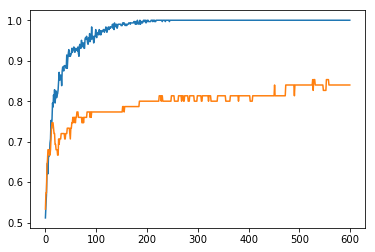

In [76]:
idx=3
plt.plot(history_list[idx].history['binary_accuracy'])
plt.plot(history_list[idx].history['val_binary_accuracy'])
plt.show()

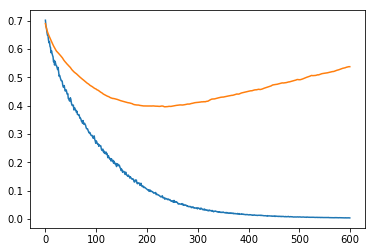

In [77]:
plt.plot(history_list[idx].history['loss'])
plt.plot(history_list[idx].history['val_loss'])
plt.show()

In [82]:
# from sklearn.metrics import confusion_matrix
# print(confusion_matrix(label_list[idx], y_pred_list[idx]))

# from sklearn.metrics import f1_score
# f1_score(label_list[idx], y_pred_list[idx])

In [79]:
model.save('NN_Dana.h5')

In [80]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

qq = model.predict(X_test)
yy = []
for ii in range(len(model.predict(X_test))):
    if model.predict(X_test)[ii][0] > model.predict(X_test)[ii][1]:
        yy.append(0)
    else:
        yy.append(1)
        
print(confusion_matrix(y_test,yy))
print('F1', f1_score(yy, y_test))
accuracy_score(yy, y_test)

[[22  3]
 [ 1 16]]
F1 0.888888888889


0.90476190476190477

In [81]:
from sklearn.metrics import accuracy_score
for aaa in range(5):
    qq = model.predict(X_test)
    yy = []
    for ii in range(len(testPredY[aaa])):
        if testPredY[aaa][ii][0] > testPredY[aaa][ii][1]:
            yy.append(0)
        else:
            yy.append(1)

    print(accuracy_score(yy, y_test))
    print(confusion_matrix(y_test,yy))

0.785714285714
[[20  5]
 [ 4 13]]
0.880952380952
[[22  3]
 [ 2 15]]
0.857142857143
[[23  2]
 [ 4 13]]
0.809523809524
[[22  3]
 [ 5 12]]
0.904761904762
[[22  3]
 [ 1 16]]
